# **Classification Model with Spark**

In [ ]:
"""
built a classification model using PySpark to predict whether a person's income exceeds $50K/year based on census data.
"""

#!pip install pyspark findspark

import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import length, substring, when, col, lit, regexp_replace
import numpy as np

# Create Spark session
spark = SparkSession.builder \
    .appName("Adult Income Classification") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Download the Adult Income dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data -O adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test -O adult.test

# Define column names for the dataset
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race",
    "sex", "capital-gain", "capital-loss", "hours-per-week",
    "native-country", "income"
]

# Load the training dataset
train_data = spark.read.csv("adult.data", header=False, inferSchema=True)
train_data = train_data.toDF(*column_names)

# Load the test dataset (remove first line which contains a description)
!sed '1d' adult.test > adult_test_clean.csv
test_data = spark.read.csv("adult_test_clean.csv", header=False, inferSchema=True)
test_data = test_data.toDF(*column_names)

# Clean the income column
test_data = test_data.withColumn("income", regexp_replace(col("income"), "\\.$", ""))

# Display data info
print("Dataset overview:")
train_data.printSchema()
print(f"Training data count: {train_data.count()}")
print(f"Test data count: {test_data.count()}")
train_data.show(5)

# Data preprocessing
# Identify categorical and numerical columns
categorical_cols = ["workclass", "education", "marital-status", "occupation",
                    "relationship", "race", "sex", "native-country"]
numerical_cols = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

# Create pipeline stages for preprocessing
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep")
            for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_enc")
            for col in categorical_cols]

# Label indexer for the target variable
label_indexer = StringIndexer(inputCol="income", outputCol="label")

# Combine all feature columns
encoded_cols = [f"{col}_enc" for col in categorical_cols]
feature_cols = numerical_cols + encoded_cols

# Create vector assembler for feature vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Create and train the Random Forest Classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)

# Create the pipeline
pipeline = Pipeline(stages=indexers + encoders + [label_indexer, assembler, rf])

# Train the model
print("Training the model...")
model = pipeline.fit(train_data)

# Make predictions on test data
print("Making predictions on test data...")
predictions = model.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="label",
                                         rawPredictionCol="rawPrediction",
                                         metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"Area Under ROC: {auc}")

# Display feature importance
feature_importance = model.stages[-1].featureImportances.toArray()
feature_importance_list = [(feature, importance) for feature, importance in zip(feature_cols, feature_importance)]
feature_importance_list.sort(key=lambda x: x[1], reverse=True)
print("\nFeature Importance:")
for feature, importance in feature_importance_list[:10]:
    print(f"{feature}: {importance}")

# Show prediction examples
print("\nSample predictions:")
predictions.select("age", "education", "occupation", "income", "probability", "prediction").show(10)

# Save the model
model.write().overwrite().save("adult_income_classifier")
print("Model saved as 'adult_income_classifier'")

# Stop the Spark session
spark.stop()

--2025-04-24 13:25:16--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [    <=>             ]   3.79M  5.45MB/s    in 0.7s    

2025-04-24 13:25:17 (5.45 MB/s) - ‘adult.data’ saved [3974305]

--2025-04-24 13:25:17--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.test’

adult.test              [  <=>               ]   1.91M  4.85MB/s    in 0.4s    

2025-04-24 13:25:17 (4.85 MB/s) - ‘adult.test’ saved [2003153]

Datase

# **Clustering Model with Spark**

--2025-04-24 13:49:44--  https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘online_retail.xlsx’

online_retail.xlsx      [    <=>             ]  22.62M  33.4MB/s    in 0.7s    

2025-04-24 13:49:45 (33.4 MB/s) - ‘online_retail.xlsx’ saved [23715344]

Dataset overview:
root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: double (nullable = true)
 |-- Country: string (nullable = true)

Total records: 541909
+---------+---------+--------------------+--------+-------------------+---------+----------+----

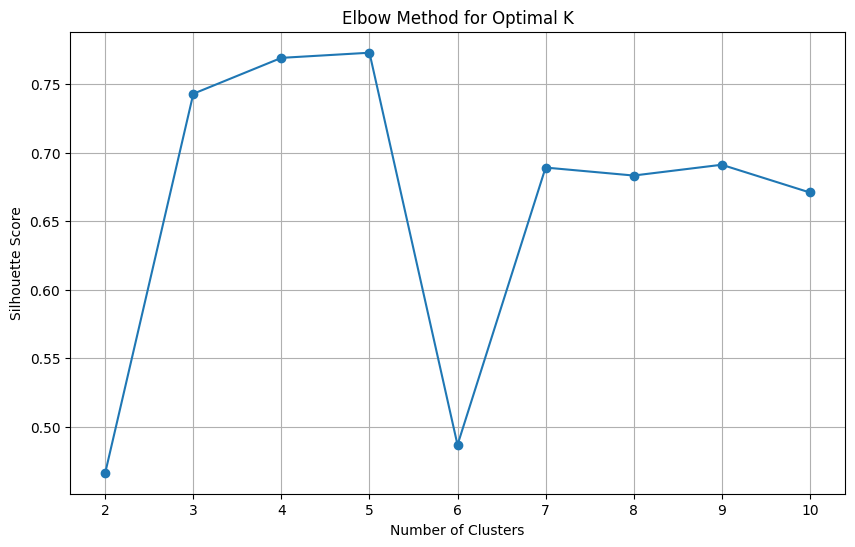


Chosen optimal number of clusters: 4
Silhouette score: 0.7691039320608096

Cluster Centers (scaled features):
Cluster 0: [ 1.56907064 -0.27942878 -0.17396593]
Cluster 1: [-0.47988987 -0.08875734 -0.08225743]
Cluster 2: [-0.76065016  1.6064516   0.99387344]
Cluster 3: [-0.87685084 11.74547011 14.83646963]

Cluster Statistics:
+----------+-----------+----------+------------+-----------+
|prediction|ClusterSize|AvgRecency|AvgFrequency|AvgMonetary|
+----------+-----------+----------+------------+-----------+
|         0|       1055|    248.99|       27.79|     490.45|
|         1|       3003|     44.06|       71.41|    1314.84|
|         2|        269|     15.99|      459.25|   10988.42|
|         3|         11|      4.36|     2778.91|  135422.71|
+----------+-----------+----------+------------+-----------+



<ipython-input-14-95e0a0d79e39>:171: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pandas_df, x="prediction", palette="viridis")


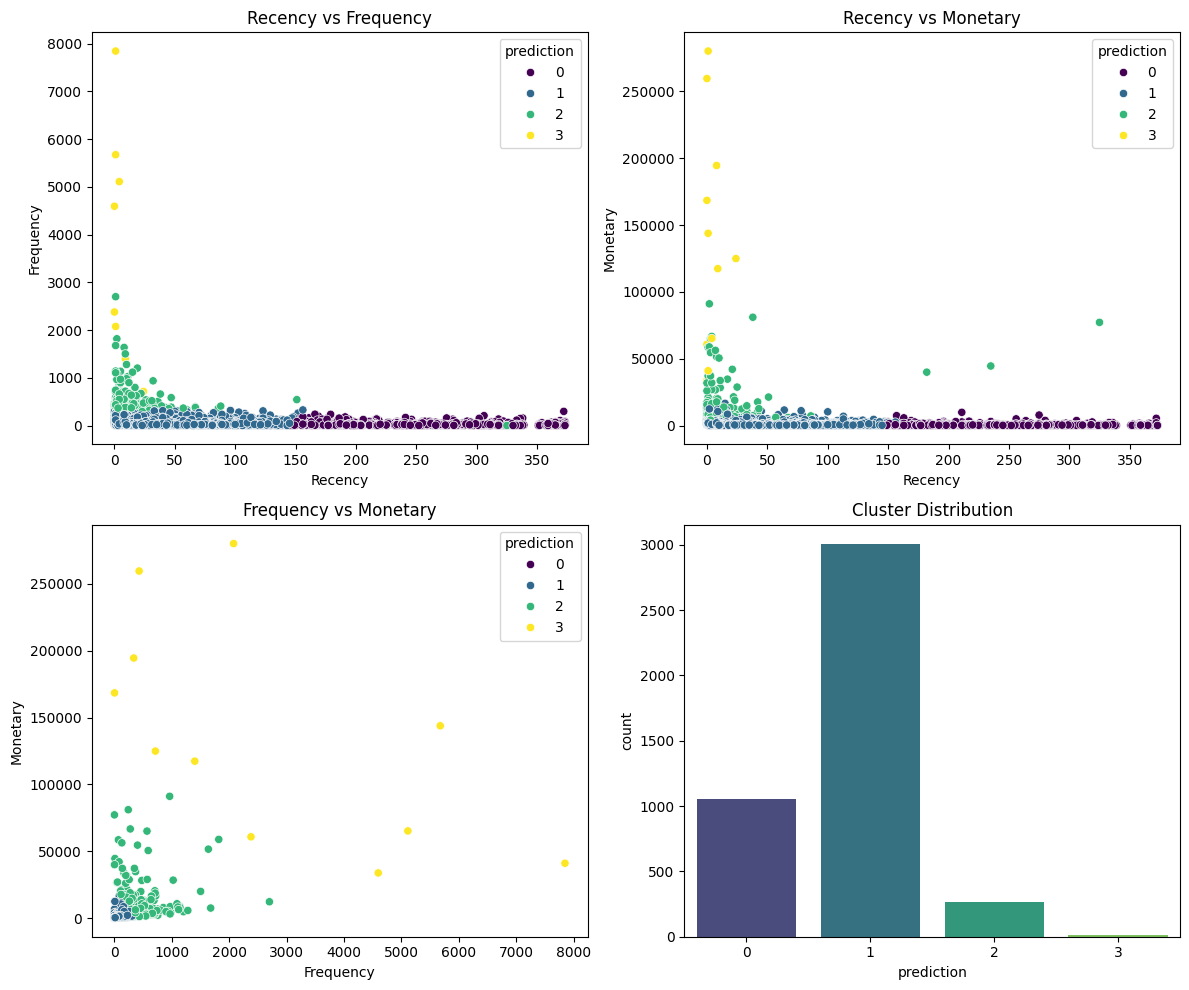


Customer Segment Interpretation:
Cluster 0.0 (1055.0 customers, 24.3%):
  - Average days since last purchase: 248.99
  - Average number of purchases: 27.79
  - Average spending: $490.45
  → These are your STANDARD customers

Cluster 1.0 (3003.0 customers, 69.2%):
  - Average days since last purchase: 44.06
  - Average number of purchases: 71.41
  - Average spending: $1314.84
  → These are your STANDARD customers

Cluster 2.0 (269.0 customers, 6.2%):
  - Average days since last purchase: 15.99
  - Average number of purchases: 459.25
  - Average spending: $10988.42
  → These are your HIGH-VALUE LOYAL customers (frequent purchases, high spending)

Cluster 3.0 (11.0 customers, 0.3%):
  - Average days since last purchase: 4.36
  - Average number of purchases: 2778.91
  - Average spending: $135422.71
  → These are your HIGH-VALUE LOYAL customers (frequent purchases, high spending)

Model saved as 'customer_segmentation_model'


In [ ]:
"""
implemented K-means clustering with PySpark to segment customers based on their purchasing behavior.
"""

import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark.sql.functions import col, count, avg, round, max, sum, datediff, to_date, lit

# Create Spark session
spark = SparkSession.builder \
    .appName("Customer Segmentation Clustering") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Download the Online Retail dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx -O online_retail.xlsx

# Convert Excel to CSV for easier processing in Spark
import pandas as pd
excel_data = pd.read_excel('online_retail.xlsx')
excel_data.to_csv('online_retail.csv', index=False)

# Load the dataset
df = spark.read.csv('online_retail.csv', header=True, inferSchema=True)

# Display data overview
print("Dataset overview:")
df.printSchema()
print(f"Total records: {df.count()}")
df.show(5)

# Data preprocessing
# Remove rows with missing values
df = df.dropna()

# Remove rows with negative quantities or prices
df = df.filter((col("Quantity") > 0) & (col("UnitPrice") > 0))

# Create customer-level features (RFM - Recency, Frequency, Monetary)
# Convert invoice date to date type if needed
if "InvoiceDate" in df.columns:
    df = df.withColumn("InvoiceDate", to_date(col("InvoiceDate")))

# Find the most recent purchase date
max_date = df.agg(max("InvoiceDate")).collect()[0][0]

# Calculate RFM metrics per customer
rfm_data = df.groupBy("CustomerID").agg(
    datediff(lit(max_date), max("InvoiceDate")).alias("Recency"),
    count("InvoiceNo").alias("Frequency"),
    sum(col("Quantity") * col("UnitPrice")).alias("Monetary")
)

# Display RFM data
print("\nRFM data sample:")
rfm_data.show(5)

# Feature preprocessing
# Vector assembly - FIXED: Ensure inputCols is a list, not a generator
feature_cols = ["Recency", "Frequency", "Monetary"]
assembler = VectorAssembler(
    inputCols=feature_cols,  # Make sure this is a list, not a generator expression
    outputCol="features"
)

# Scale features
scaler = StandardScaler(
    inputCol="features",
    outputCol="scaledFeatures",
    withStd=True,
    withMean=True
)

# Find optimal number of clusters using Elbow method
wcss = []
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(k=k, seed=1, featuresCol="scaledFeatures")
    pipeline_model = Pipeline(stages=[assembler, scaler, kmeans]).fit(rfm_data)
    predictions = pipeline_model.transform(rfm_data)
    evaluator = ClusteringEvaluator(featuresCol="scaledFeatures")
    score = evaluator.evaluate(predictions)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score={score}")

# Plot Elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 11))
plt.grid(True)
plt.show()

# Based on the elbow curve, select the optimal number of clusters
optimal_k = 4
print(f"\nChosen optimal number of clusters: {optimal_k}")

# Train the K-means model with the optimal number of clusters
kmeans = KMeans(k=optimal_k, seed=1, featuresCol="scaledFeatures")
pipeline = Pipeline(stages=[assembler, scaler, kmeans])
model = pipeline.fit(rfm_data)

# Make predictions
predictions = model.transform(rfm_data)

# Evaluate clustering performance
evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="scaledFeatures")
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette score: {silhouette}")

# Display cluster centers
centers = model.stages[-1].clusterCenters()
print("\nCluster Centers (scaled features):")
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

# Analyze cluster characteristics
cluster_stats = predictions.groupBy("prediction").agg(
    count("*").alias("ClusterSize"),
    round(avg("Recency"), 2).alias("AvgRecency"),
    round(avg("Frequency"), 2).alias("AvgFrequency"),
    round(avg("Monetary"), 2).alias("AvgMonetary")
)

print("\nCluster Statistics:")
cluster_stats.orderBy("prediction").show()

# Convert to Pandas for visualization
select_cols = ["CustomerID", "Recency", "Frequency", "Monetary", "prediction"]
pandas_df = predictions.select(*select_cols).toPandas()

# Visualize clusters
plt.figure(figsize=(12, 10))

# Plot 1: Recency vs Frequency
plt.subplot(2, 2, 1)
sns.scatterplot(data=pandas_df, x="Recency", y="Frequency", hue="prediction", palette="viridis")
plt.title("Recency vs Frequency")

# Plot 2: Recency vs Monetary
plt.subplot(2, 2, 2)
sns.scatterplot(data=pandas_df, x="Recency", y="Monetary", hue="prediction", palette="viridis")
plt.title("Recency vs Monetary")

# Plot 3: Frequency vs Monetary
plt.subplot(2, 2, 3)
sns.scatterplot(data=pandas_df, x="Frequency", y="Monetary", hue="prediction", palette="viridis")
plt.title("Frequency vs Monetary")

# Plot 4: Cluster Distribution
plt.subplot(2, 2, 4)
sns.countplot(data=pandas_df, x="prediction", palette="viridis")
plt.title("Cluster Distribution")

plt.tight_layout()
plt.show()

# Interpret clusters and provide business insights
print("\nCustomer Segment Interpretation:")
cluster_stats_pd = cluster_stats.toPandas().sort_values("prediction")

for idx, row in cluster_stats_pd.iterrows():
    cluster = row["prediction"]
    size = row["ClusterSize"]
    recency = row["AvgRecency"]
    frequency = row["AvgFrequency"]
    monetary = row["AvgMonetary"]

    percentage = size / pandas_df.shape[0] * 100

    print(f"Cluster {cluster} ({size} customers, {percentage:.1f}%):")
    print(f"  - Average days since last purchase: {recency}")
    print(f"  - Average number of purchases: {frequency}")
    print(f"  - Average spending: ${monetary:.2f}")

    # Interpret the segment
    if recency < 30 and frequency > 10 and monetary > 1000:
        print("  → These are your HIGH-VALUE LOYAL customers (frequent purchases, high spending)")
    elif recency < 30 and frequency > 5:
        print("  → These are your ACTIVE customers (recent, regular purchases)")
    elif recency > 60 and frequency > 5 and monetary > 500:
        print("  → These are your AT-RISK HIGH-VALUE customers (used to purchase regularly but haven't recently)")
    elif recency > 60 and frequency < 5:
        print("  → These are your INACTIVE customers (haven't purchased recently, low frequency)")
    elif monetary > 500 and frequency < 5:
        print("  → These are your BIG SPENDERS (high average order value but infrequent)")
    else:
        print("  → These are your STANDARD customers")
    print()

# Save the model
model.write().overwrite().save("customer_segmentation_model")
print("Model saved as 'customer_segmentation_model'")

# Stop Spark session
spark.stop()

# **Recommendation Engine with Spark**

Ratings dataset overview:
root
 |-- user_id: integer (nullable = true)
 |-- book_id: integer (nullable = true)
 |-- rating: integer (nullable = true)

Total ratings: 5976479
+-------+-------+------+
|user_id|book_id|rating|
+-------+-------+------+
|      1|    258|     5|
|      2|   4081|     4|
|      2|    260|     5|
|      2|   9296|     5|
|      2|   2318|     3|
+-------+-------+------+
only showing top 5 rows


Books dataset overview:
root
 |-- book_id: integer (nullable = true)
 |-- goodreads_book_id: integer (nullable = true)
 |-- best_book_id: integer (nullable = true)
 |-- work_id: integer (nullable = true)
 |-- books_count: integer (nullable = true)
 |-- isbn: string (nullable = true)
 |-- isbn13: double (nullable = true)
 |-- authors: string (nullable = true)
 |-- original_publication_year: double (nullable = true)
 |-- original_title: string (nullable = true)
 |-- title: string (nullable = true)
 |-- language_code: string (nullable = true)
 |-- average_rating: string (

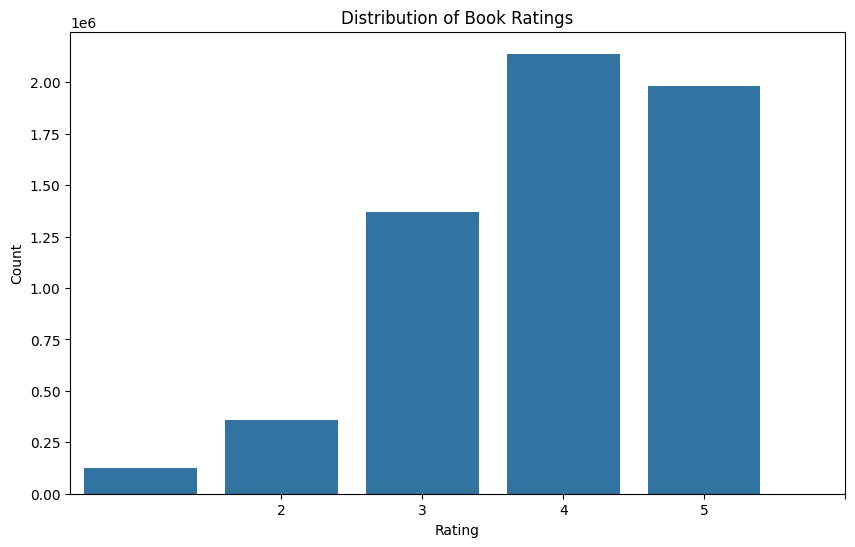


Recommendation function example output for User 12:
                                 title  \
0          The Dragonslayer (Bone, #4)   
1                   رباعيات صلاح جاهين   
2       The Complete Calvin and Hobbes   
3   Revelation (Matthew Shardlake, #4)   
4   Locke & Key, Vol. 6: Alpha & Omega   
5      Locke & Key, Vol. 5: Clockworks   
6        Berserk, Vol. 1 (Berserk, #1)   
7      Locke & Key, Vol. 2: Head Games   
8  The Indispensable Calvin and Hobbes   
9   Ms. Marvel, Vol. 2: Generation Why   

                                         authors  predicted_rating  
0                      Jeff Smith, Steve Hamaker          4.717223  
1                           صلاح جاهين, يحيى حقي          4.616101  
2                                 Bill Watterson          4.612035  
3                                    C.J. Sansom          4.592244  
4                    Joe Hill, Gabriel Rodríguez          4.546735  
5                    Joe Hill, Gabriel Rodríguez          4.531202  
6

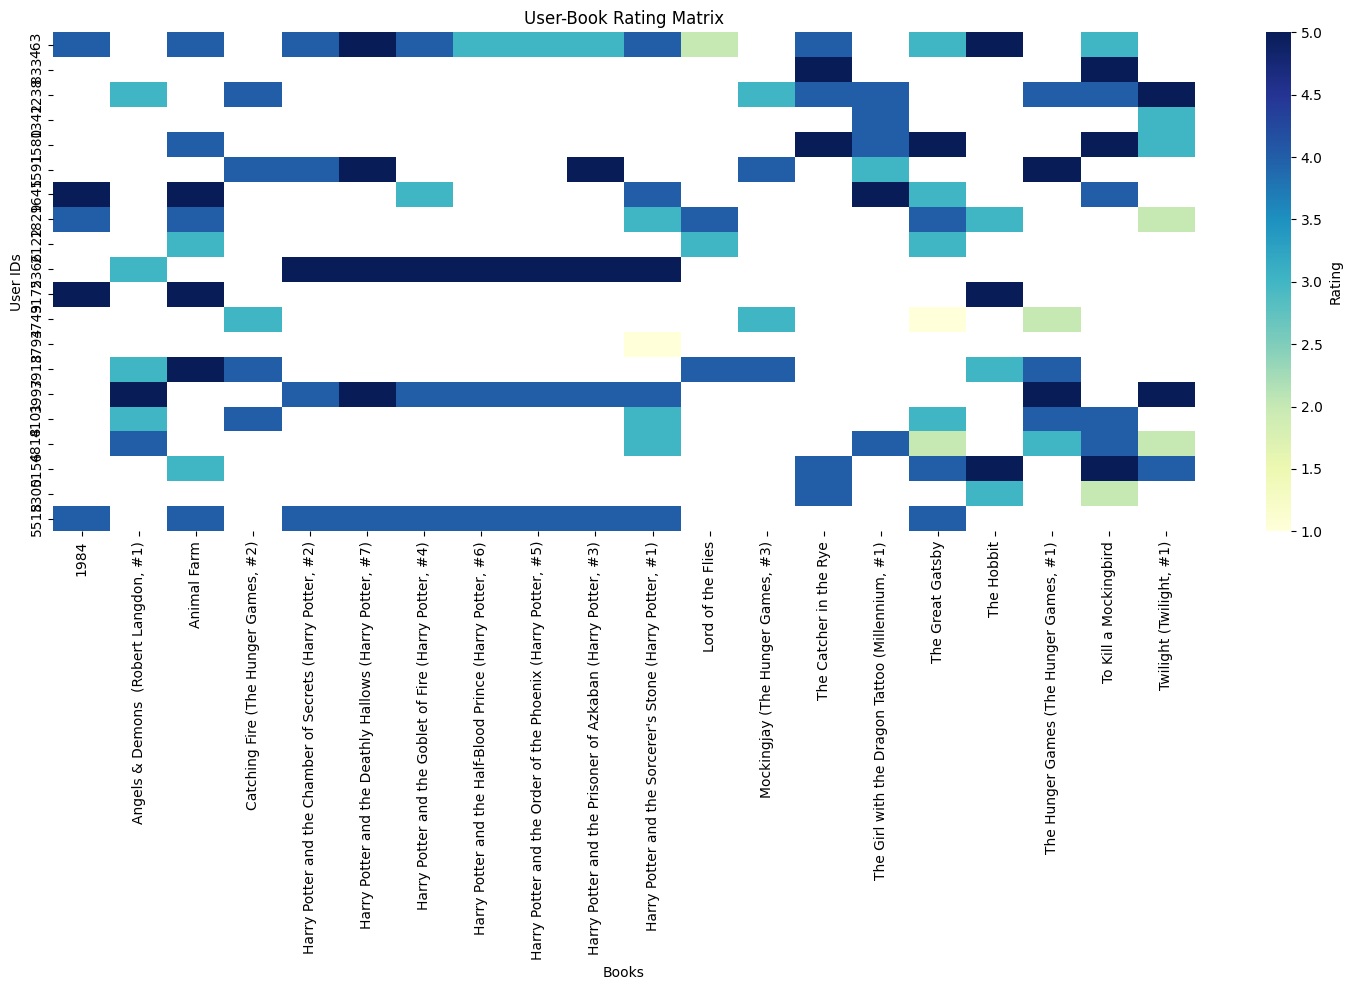

In [2]:
"""
built a recommendation system using PySpark's Alternating Least Squares (ALS) algorithm
on the Goodreads books dataset to recommend books to users.
"""

# Install required packages for Spark in Colab
#!pip install pyspark findspark pandas numpy matplotlib seaborn

# Import libraries
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, explode, count, desc, round as spark_round
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create Spark session
spark = SparkSession.builder \
    .appName("Book Recommendation Engine") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Download Goodreads dataset (10k sample)
# Note: Using a small sample for demonstration purposes
!wget -q https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/ratings.csv
!wget -q https://raw.githubusercontent.com/zygmuntz/goodbooks-10k/master/books.csv

# Load the ratings and books data
ratings = spark.read.csv("ratings.csv", header=True, inferSchema=True)
books = spark.read.csv("books.csv", header=True, inferSchema=True)

# Display data overview
print("Ratings dataset overview:")
ratings.printSchema()
print(f"Total ratings: {ratings.count()}")
ratings.show(5)

print("\nBooks dataset overview:")
books.printSchema()
print(f"Total books: {books.count()}")
books.select("book_id", "title", "authors", "average_rating").show(5, truncate=False)

# Basic data analysis
print("\nRatings distribution:")
ratings.groupBy("rating").count().orderBy("rating").show()

print("\nTop 10 books by number of ratings:")
top_books = ratings.groupBy("book_id").count().orderBy(desc("count")).limit(10)
top_books_with_info = top_books.join(books, on="book_id")
top_books_with_info.select("title", "authors", "count").show(truncate=False)

# Convert to numeric IDs if needed and keep only necessary columns
ratings = ratings.select("user_id", "book_id", "rating")

# Split the dataset into training and test sets
(training, test) = ratings.randomSplit([0.8, 0.2], seed=42)

print(f"Training set size: {training.count()}")
print(f"Test set size: {test.count()}")

# Build the recommendation model using ALS on the training data
print("\nTraining the ALS model...")

# Hyperparameter tuning
best_rmse = float('inf')
best_model = None
best_rank = 0
best_regParam = 0
best_alpha = 0

ranks = [10, 20]
regParams = [0.1, 0.01]
alphas = [1.0, 0.5]

for rank in ranks:
    for regParam in regParams:
        for alpha in alphas:
            # Build the recommendation model using ALS
            als = ALS(
                maxIter=10,
                rank=rank,
                regParam=regParam,
                alpha=alpha,
                userCol="user_id",
                itemCol="book_id",
                ratingCol="rating",
                coldStartStrategy="drop",
                nonnegative=True
            )

            model = als.fit(training)

            # Evaluate the model
            predictions = model.transform(test)
            evaluator = RegressionEvaluator(
                metricName="rmse",
                labelCol="rating",
                predictionCol="prediction"
            )
            rmse = evaluator.evaluate(predictions)

            print(f"RMSE = {rmse:.4f} for rank={rank}, regParam={regParam}, alpha={alpha}")

            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model
                best_rank = rank
                best_regParam = regParam
                best_alpha = alpha

print(f"\nBest model parameters: rank={best_rank}, regParam={best_regParam}, alpha={best_alpha}")
print(f"Best RMSE = {best_rmse:.4f}")

# Use the best model for subsequent analysis
model = best_model

# Generate top 10 book recommendations for a subset of users
num_users = 5
users = ratings.select("user_id").distinct().limit(num_users)
userRecs = model.recommendForUserSubset(users, 10)

print("\nTop 10 book recommendations for 5 users:")
userRecs.show(truncate=False)

# Generate top 10 user recommendations for a subset of books
num_books = 5
books_subset = ratings.select("book_id").distinct().limit(num_books)
bookRecs = model.recommendForItemSubset(books_subset, 10)

print("\nTop 10 user recommendations for 5 books:")
bookRecs.show(truncate=False)

# Get book titles for the recommendations
def get_book_info(book_id):
    """Get book title and author for a book ID"""
    book_info = books.filter(col("book_id") == book_id).select("title", "authors").collect()
    if book_info:
        return book_info[0]["title"], book_info[0]["authors"]
    return "Unknown", "Unknown"

# Detailed recommendations for a specific user
user_id = 42  # Choose a specific user
user_recs = model.recommendForUserSubset(spark.createDataFrame([(user_id,)], ["user_id"]), 10)

# Display recommendations with book titles
user_recs_exploded = user_recs.select(
    col("user_id"),
    explode(col("recommendations")).alias("recommendation")
)

# Create a DataFrame with recommendation details
user_recs_details = user_recs_exploded.select(
    col("user_id"),
    col("recommendation.book_id").alias("book_id"),
    col("recommendation.rating").alias("predicted_rating")
)

# Join with books information
user_recs_with_details = user_recs_details.join(books, on="book_id")

print(f"\nTop 10 book recommendations for User {user_id}:")
user_recs_with_details.select(
    "user_id", "title", "authors", "predicted_rating"
).orderBy(col("predicted_rating").desc()).show(truncate=False)

# Calculate similarities between books
# Convert item factors to local Python objects for similarity calculation
book_factors = model.itemFactors
book_factors_local = book_factors.collect()

# Function to convert factors to lists to avoid generator issues
book_factors_dict = {row.id: list(row.features) for row in book_factors_local}

# Function to compute cosine similarity
def cosine_similarity(vec1, vec2):
    # Ensure vectors are lists, not generators
    vec1 = list(vec1) if not isinstance(vec1, list) else vec1
    vec2 = list(vec2) if not isinstance(vec2, list) else vec2

    dot_product = sum(a * b for a, b in zip(vec1, vec2))
    norm1 = sum(a * a for a in vec1) ** 0.5
    norm2 = sum(b * b for b in vec2) ** 0.5
    return dot_product / (norm1 * norm2) if norm1 * norm2 != 0 else 0

# Get a popular book to find similar books
popular_book = ratings.groupBy("book_id").count().orderBy(desc("count")).select("book_id").first()[0]
popular_book_title, popular_book_author = get_book_info(popular_book)

# Find similar books
similarities = []
for book_id, factors in book_factors_dict.items():
    if book_id != popular_book and book_id in book_factors_dict:
        similarity = cosine_similarity(book_factors_dict[popular_book], factors)
        similarities.append((book_id, similarity))

# Sort by similarity
similarities.sort(key=lambda x: x[1], reverse=True)

# Display top 10 similar books
print(f"\nTop 10 books similar to '{popular_book_title}' by {popular_book_author}:")
for book_id, similarity in similarities[:10]:
    title, author = get_book_info(book_id)
    print(f"{title} by {author}: Similarity = {similarity:.4f}")

# Visualize rating distribution
plt.figure(figsize=(10, 6))
rating_counts = ratings.groupBy("rating").count().orderBy("rating").toPandas()
sns.barplot(x="rating", y="count", data=rating_counts)
plt.title("Distribution of Book Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks(range(1, 6))
plt.show()

# Implement a function for getting real-time recommendations
def get_recommendations_for_user(user_id, num_recs=10):
    """Get book recommendations for a specific user."""
    user_df = spark.createDataFrame([(user_id,)], ["user_id"])
    user_recs = model.recommendForUserSubset(user_df, num_recs)

    # Extract recommendations
    user_recs_exploded = user_recs.select(
        col("user_id"),
        explode(col("recommendations")).alias("recommendation")
    )

    # Join with book details
    user_recs_with_details = user_recs_exploded.select(
        col("user_id"),
        col("recommendation.book_id").alias("book_id"),
        col("recommendation.rating").alias("predicted_rating")
    ).join(books, on="book_id")

    # Convert to pandas for easier handling
    recommendations_pd = user_recs_with_details.select(
        "user_id", "book_id", "title", "authors", "predicted_rating"
    ).orderBy(col("predicted_rating").desc()).toPandas()

    return recommendations_pd

# Example usage
user_recommendations = get_recommendations_for_user(12, 10)
print("\nRecommendation function example output for User 12:")
print(user_recommendations[["title", "authors", "predicted_rating"]].head(10))

# Visualize top book genres
# Note: Depending on the dataset, you might need to extract genres from a different field
if "genres" in books.columns:
    print("\nTop book genres in the dataset:")
    books.select(explode(col("genres")).alias("genre")).groupBy("genre").count().orderBy(desc("count")).show(10)
else:
    print("\nGenre information not available in this dataset.")

# Implement a simple book search function
def search_books(query, limit=10):
    """Search for books by title or author"""
    matching_books = books.filter(
        col("title").contains(query) | col("authors").contains(query)
    ).select("book_id", "title", "authors", "average_rating")

    return matching_books.orderBy(desc("average_rating")).limit(limit)

# Example search
search_query = "Harry Potter"
matching_books = search_books(search_query)
print(f"\nBooks matching '{search_query}':")
matching_books.show(truncate=False)

# Create a function to get personalized recommendations based on a book
def get_recommendations_by_book(book_title, num_recs=10):
    """Get book recommendations similar to a specified book."""
    # Find the book ID
    book_info = books.filter(col("title").contains(book_title)).select("book_id").first()

    if not book_info:
        return f"No book found matching '{book_title}'"

    book_id = book_info["book_id"]

    # Find similar books
    similarities = []
    for other_id, factors in book_factors_dict.items():
        if other_id != book_id and other_id in book_factors_dict:
            similarity = cosine_similarity(book_factors_dict[book_id], factors)
            similarities.append((other_id, similarity))

    # Sort by similarity
    similarities.sort(key=lambda x: x[1], reverse=True)

    # Get top N similar books
    similar_book_ids = [book_id for book_id, _ in similarities[:num_recs]]

    # Get book details
    similar_books = books.filter(col("book_id").isin(similar_book_ids))

    return similar_books.select("title", "authors", "average_rating")

# Example book recommendation
sample_book = "The Hunger Games"
similar_books = get_recommendations_by_book(sample_book)
print(f"\nBooks similar to '{sample_book}':")
similar_books.show(truncate=False)

# Save the model
model.write().overwrite().save("book_recommender_model")
print("Model saved as 'book_recommender_model'")

# Visualize user reading patterns
# Sample a subset of users and books for visualization
sample_users = ratings.select("user_id").distinct().limit(20).toPandas()["user_id"].tolist()
sample_books = ratings.groupBy("book_id").count().orderBy(desc("count")).limit(20).toPandas()["book_id"].tolist()

# Filter ratings for sampled users and books
sample_ratings = ratings.filter(
    (col("user_id").isin(sample_users)) &
    (col("book_id").isin(sample_books))
)

# Join with book titles
sample_ratings_with_titles = sample_ratings.join(
    books.select("book_id", "title"),
    on="book_id"
).select("user_id", "book_id", "title", "rating")

# Pivot to create user-book matrix
try:
    rating_matrix = sample_ratings_with_titles.toPandas().pivot(
        index="user_id", columns="title", values="rating"
    )

    # Visualize as heatmap
    plt.figure(figsize=(15, 10))
    sns.heatmap(rating_matrix, cmap="YlGnBu", annot=False, cbar_kws={'label': 'Rating'})
    plt.title("User-Book Rating Matrix")
    plt.xlabel("Books")
    plt.ylabel("User IDs")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
except:
    print("Unable to create heatmap visualization due to data size or format limitations.")

# Stop Spark session
spark.stop()